In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = 'files/'
dates_cols = ['date_activ','date_end','date_first_activ','date_modif_prod','date_renewal']
cat_cols = ['activity_new', 'channel_sales', 'has_gas', 'origin_up']
target_cols = ['churn']

training_data = pd.read_csv(path+'ml_case_training_data.csv', parse_dates=dates_cols).dropna(axis=1, how='all')
training_hist_data = pd.read_csv(path+'ml_case_training_hist_data.csv')
training_output = pd.read_csv(path+'ml_case_training_output.csv')
test_data = pd.read_csv(path+'ml_case_test_data.csv', parse_dates=dates_cols, usecols=training_data.columns)
test_hist_data = pd.read_csv(path+'ml_case_test_hist_data.csv')

In [3]:
prices = ['price_p1_fix','price_p1_var','price_p2_fix','price_p2_var','price_p3_fix','price_p3_var']
df_hist_data = training_hist_data.append(test_hist_data).pivot_table(index='id', columns='price_date', values=prices)
df_hist_data.columns = ['_'.join(col).strip().replace('-','') for col in df_hist_data.columns.values]
ts_cols = df_hist_data.columns.tolist()

In [4]:
all_cols = training_data.columns.tolist()
num_cols = list(set(all_cols)-set(dates_cols)-set(ts_cols)-set(target_cols)-set(cat_cols)-set(['id']))
num_cols = [c for c in num_cols if 'forecast' not in c]
features = num_cols + cat_cols + dates_cols + ts_cols
len(features)

91

# monthly prices evolution

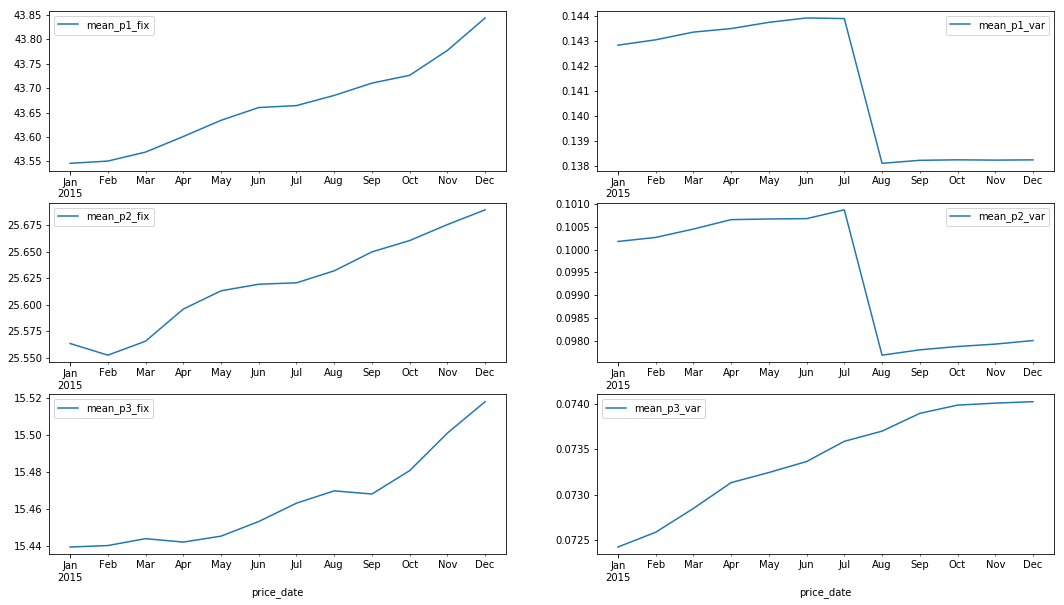

In [5]:
df = training_hist_data.append(test_hist_data).replace(0, np.nan)
df.price_date = pd.to_datetime(df.price_date)

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10);fig.set_figwidth(18)

for i,c in enumerate(prices):
    df.groupby('price_date')[c].mean().plot(ax=axes[i//2,i%2])
    axes[i//2,i%2].legend(['mean_'+c[6:]])

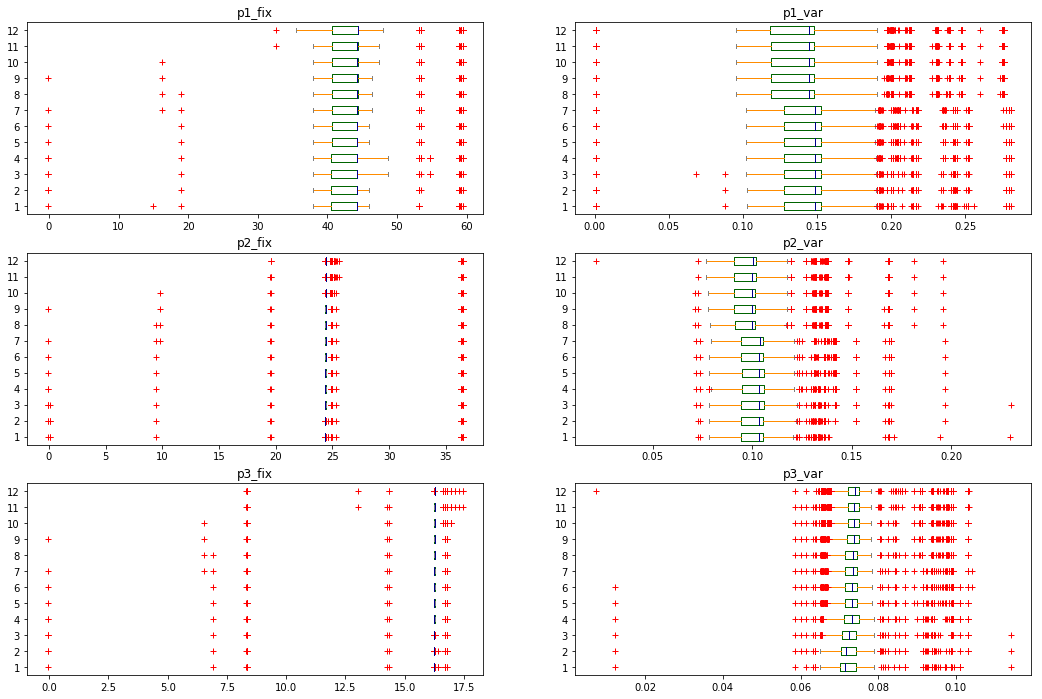

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(12);fig.set_figwidth(18)

for i,c in enumerate(prices):
    tmp = df[['id','price_date',c]]
    df.pivot(index='id', columns='price_date', 
             values=c).rename(lambda x: x.month, axis='columns').plot.box(ax=axes[i//2,i%2],
             color=dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray'), sym='r+',
             vert=False)
    axes[i//2,i%2].set_title(c[6:])

# cleaning and basic feature engineering

In [7]:
def get_df(scale=False, fillna=False):
    
    global training_data, training_output, test_data, df_hist_data, cat_cols, dates_cols, ts_cols, num_cols
    df = training_data.merge(training_output).append(test_data).set_index('id').join(df_hist_data)
    means = {}
    stds = {}
    
    for c in df.columns:
        if c in cat_cols:
            print('cat %s' % c)
            df[c] = df[c].astype('category').cat.codes
        elif c in dates_cols:
            print('date % s' % c)
            df[c] = pd.datetime(2016,1,1)-df[c]
            df.loc[df[c].notnull(), c] = df.loc[df[c].notnull(), c].dt.days.astype(int)
        if scale and c in dates_cols+ts_cols+num_cols:
            means[c]=df.loc[df.churn.notnull(), c].mean()
            stds[c]=df.loc[df.churn.notnull(), c].std()
            df[c]=((df[c]-means[c])/stds[c])
        if fillna and c in dates_cols+ts_cols+num_cols:
            df[c].fillna(df.loc[df.churn.notnull(), c].mean(), inplace=True)
            
    return df

df=get_df()

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


Viewing churning clients relative to some features

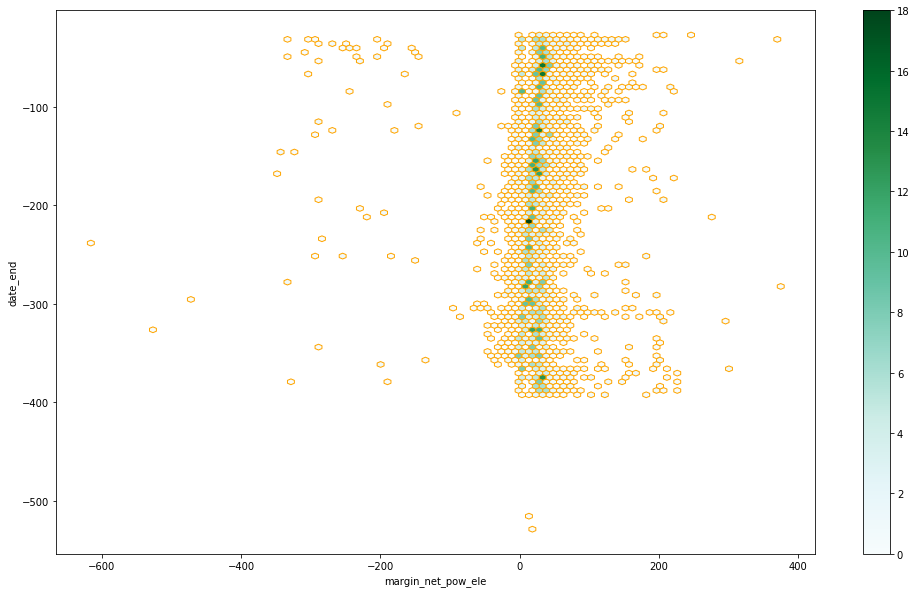

In [8]:
df.loc[(df.date_end<365)&(df.date_end>-365*2),
       ['margin_net_pow_ele','date_end','churn']].dropna().astype(float).plot.hexbin(
            x='margin_net_pow_ele', y='date_end', C='churn', reduce_C_function=np.sum, 
            gridsize=100, sharex=False, figsize=(17,10), color='orange')

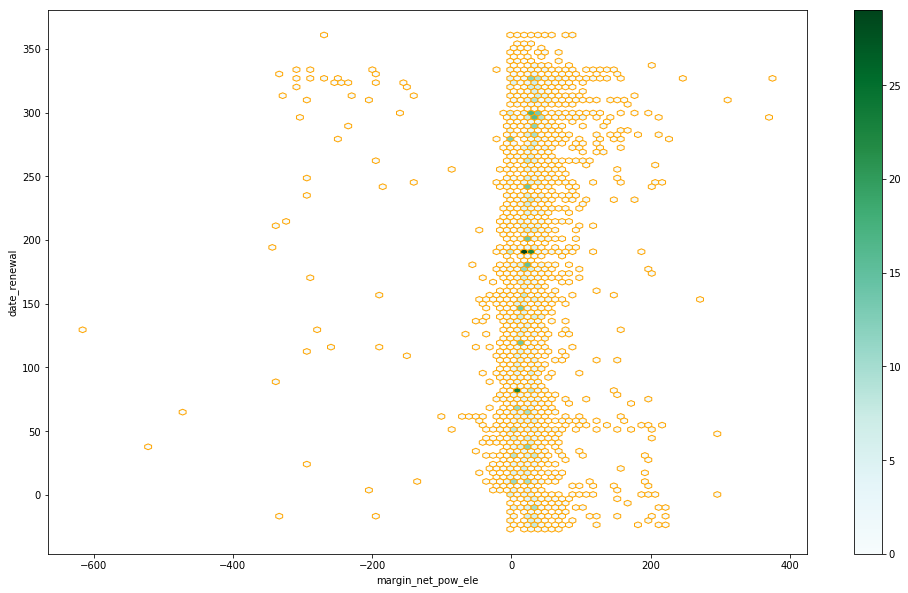

In [9]:
df.loc[(df.date_renewal<365)&(df.date_renewal>-365*2),
       ['margin_net_pow_ele','date_renewal','churn']].dropna().astype(float).plot.hexbin(
            x='margin_net_pow_ele', y='date_renewal', C='churn', reduce_C_function=np.sum, 
            gridsize=100, sharex=False, figsize=(17,10), color='orange')